# Using A "REFoCUS Wavefront Model" With A Custom Speed-Of-Sound Map
In this example we will simulate the individual contributions of each active "sending" element in a focused transmit using our `REFoCUSWavefront` class, kind of similar to REFoCUS [1], but in the time-domain. We will also model how each diverging spherical propagates through a medium with a heterogeneous speed-of-sound map.

Let's start by importing the data [2] and setting up the scan.

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pyuff_ustb as pyuff

from vbeam.beamformers import get_das_beamformer
from vbeam.data_importers import import_pyuff
from vbeam.scan import sector_scan
from vbeam.util.download import cached_download

# Download and read the channel data
data_url = "http://www.ustb.no/datasets/Verasonics_P2-4_parasternal_long_small.uff"
uff = pyuff.Uff(cached_download(data_url))
channel_data = uff.read("/channel_data")

# Import the data
setup = import_pyuff(channel_data, frames=0)

# Define a scan that we want to beamform into (not included by default in this dataset)
scan_angles = jnp.array([wave.source.azimuth for wave in channel_data.sequence])
scan_depths = jnp.linspace(0e-3, 110e-3, 512)
setup.scan = sector_scan(scan_angles, scan_depths).resize(azimuths=256)

## Configuring Time-Domain REFoCUS
By default, the imported dataset uses RTB. We have to change some variables to make it run the time-domain REFoCUS method.

First of all, we set the wavefront model to be an instance of our `REFoCUSWavefront` class, which models a simple diverging spherical wave originating from an element, but also compensates for any focusing delay used during transmission.
We also set the `sender` (the element that the wave originates from) to be all elements in the array (by setting it to equal `receiver`). We must also update the spec to let vbeam know that the sender argument now consists of multiple elements. We call this new dimension `"senders"`. Lastly, we remove any apodization, as it will break when we add a speed-of-sound map later.

In [2]:
from vbeam.apodization import NoApodization
from vbeam.wavefront import REFoCUSWavefront

# Use a time-domain REFoCUS wavefront model
setup.transmitted_wavefront = REFoCUSWavefront(
    setup.transmitted_wavefront, setup.sender
)

# Each element is also modeled as a sending element (STAI)
setup.sender = setup.receiver
setup.spec = setup.spec.at["sender"].set(["senders"])

# Let's also remove any apodization in this example
setup.apodization = NoApodization()

Let's beamform this setup using the out-of-the-box beamformer, but keeping our newly defined `"senders"` dimension. We can now plot what the image looks like for each individual sending element. Keep in mind that we are still coherently compounding across the `"transmits"`, i.e. the actual transmit events of which there are 101 focused waves.

Result shape: (64, 256, 512)
Result dimensions: Spec(('senders', 'width', 'height'))


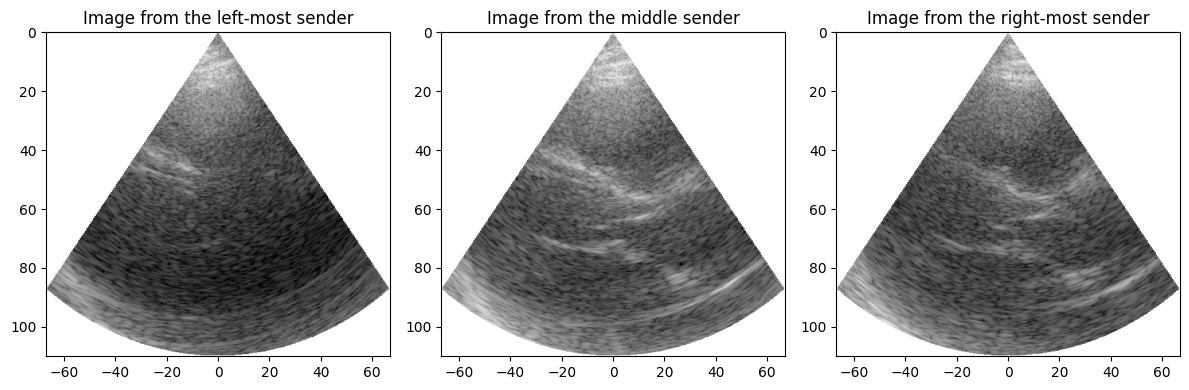

In [3]:
beamformer = jax.jit(
    get_das_beamformer(
        setup,
        keep_dimensions=["senders"],
        compensate_for_apodization_overlap=False,
    )
)
result = beamformer(**setup.data)
print("Result shape:", result.shape)
print("Result dimensions:", beamformer.output_spec)

extent = setup.scan.cartesian_bounds
extent = extent[0] * 1000, extent[1] * 1000, extent[3] * 1000, extent[2] * 1000

fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
ax[0].imshow(result[0].T, aspect="auto", extent=extent, cmap="gray", vmin=-80)
ax[1].imshow(result[32].T, aspect="auto", extent=extent, cmap="gray", vmin=-80)
ax[2].imshow(result[-1].T, aspect="auto", extent=extent, cmap="gray", vmin=-80)
ax[0].set_title("Image from the left-most sender")
ax[1].set_title("Image from the middle sender")
ax[2].set_title("Image from the right-most sender")
fig.tight_layout()

## Creating A Custom Beamformer
Let's also take a look at how to define out own custom beamformers, as there is ample room for memory optimizations when doing time-domain REFoCUS.

Currently, we are processing each pixel in a 256x512 grid, for each of the 64 receiving elements, and all 64 active "sending" element, for all 101 transmitted waves. This amounts to processing 256 x 512 x 64 x 64 x 101 ≈ 54 billion points for a single image. The out-of-the-box beamformer does all of this in parallel, allocating a huge array before summing over almost all dimensions.

You can see the beamformer algorithm in the cell below (we will also create our own version further down, where each step is explained):

In [4]:
print(beamformer)

<PjitFunction of TransformedFunction(
  <compose(
    signal_for_point,
    ForAll('points'),
    ForAll('receivers'),
    ForAll('senders'),
    ForAll('transmits'),
    Apply(JaxBackend.sum, [Axis("receivers"), Axis("transmits")]),
    Apply(Scan.unflatten, Axis("points", becomes=['width', 'height'])),
    Apply(normalized_decibels),
    Apply(scan_convert, SectorScan(<shape=(256, 512)>, apex=0.0), Axis("width", keep=True), Axis("height", keep=True)),
  )>
)>


We can reduce the amount of allocated memory by processing a single transmit event at a time, and iteratively summing the results. In vbeam/spekk there is a transformation that does this, called `Reduce.Sum`.

The cell below shows how we can build up our own custom beamformers with complete control over what dimensions to loop over and how:

In [5]:
import jax.numpy as jnp

from vbeam.core import signal_for_point
from vbeam.postprocess import normalized_decibels
from vbeam.scan import scan_convert
from vbeam.util.transformations import *

beamformer = compose(
    signal_for_point,
    # Make it run in parallel for all points (pixels), sending-, and receiving- elements
    ForAll("points"),
    ForAll("senders"),
    ForAll("receivers"),
    # We sum over all sending-, and receiving- elements
    Apply(jnp.sum, [Axis("senders"), Axis("receivers")]),
    # Iteratively sum the result of each transmit event to reduce memory usage
    Reduce.Sum("transmits"),
    # Postprocessing
    Apply(setup.scan.unflatten),  # Points are flattened by default; reshape them back
    Apply(normalized_decibels),  # Decibels, and the maximum value is normalized to 0 dB
    Apply(scan_convert, setup.scan),  # Scan convert from beam-space to cartesian space
    # Just-in-time compile the function
    Wrap(jax.jit),
    # Build the function to let vbeam know about the dimensions of the input data
).build(setup.spec)

Let's run our custom beamformer and time it. It takes around 853 ms ± 645 µs to run, which amounts to processing more than 63 billion points per second (this is of course still _way far away_ from real-time).

850 ms ± 878 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


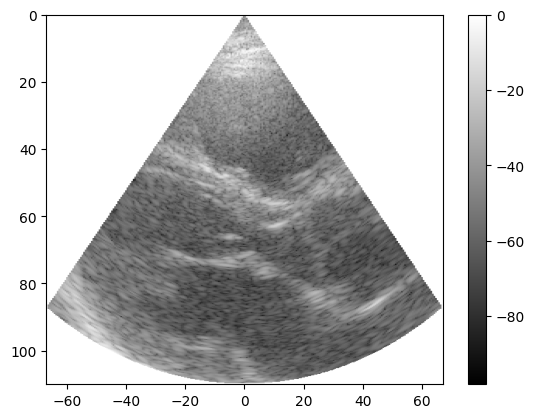

In [6]:
data = setup.data
plt.imshow(beamformer(**data).T, aspect="auto", cmap="gray", extent=extent)
plt.colorbar()
%timeit beamformer(**data).block_until_ready()

# Speed-Of-Sound Map
Lastly, let's play with using a speed-of-sound map.

As we are modeling diverging spherical waves originating from each element and going to each point, and back again to the receiving elements, we are effectively performing ray-tracing of the waves. A simple speed-of-sound model could integrate a map across these rays.

First, let's create an interesting-looking speed-of-sound map:

Text(0.5, 1.0, 'Speed of sound map')

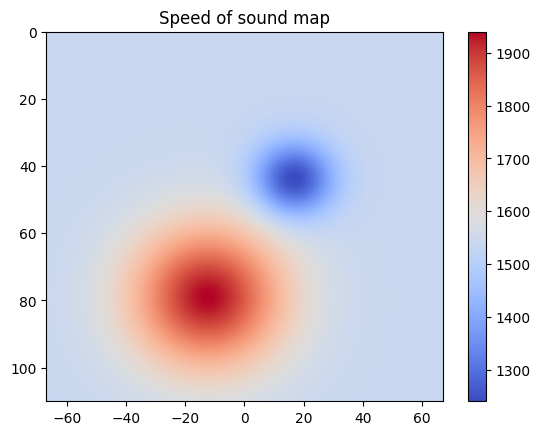

In [7]:
from vbeam.scan import util
from vbeam.speed_of_sound import HeterogeneousSpeedOfSound


@jax.jit
def get_speed_of_sound_values(scan, t):
    def blob(grid, x, y, spread=1):
        dist = jnp.sqrt((grid[..., 0] - x) ** 2 + (grid[..., 2] - y) ** 2)
        return jnp.exp(-(dist**2) * 2 / spread)

    grid = util.grid(
        jnp.linspace(-1, 1, scan.shape[0]),
        jnp.linspace(-1, 1, scan.shape[1]),
    )
    return (
        blob(grid, jnp.cos(t) * 0.5, jnp.sin(t * 2) * 0.4 + 0.15, 0.3) * 400
        - blob(grid, -0.2, 0.25, (jnp.sin(t) ** 2 + 0.1) / 4)
        * (jnp.sin(t) ** 2 + 1)
        * 250
    ) + 1540


scan150x150 = setup.scan.resize(azimuths=150, depths=150)
sos_values = get_speed_of_sound_values(scan150x150, -0.5)
plt.colorbar(plt.imshow(sos_values, aspect="auto", cmap="coolwarm", extent=extent))
plt.title("Speed of sound map")

Beamforming with this speed-of-sound map is as simple as passing in a new value for the `speed_of_sound` argument to our beamformer, as seen below.

Try changing the `sos_values` to get a feel for how it works.

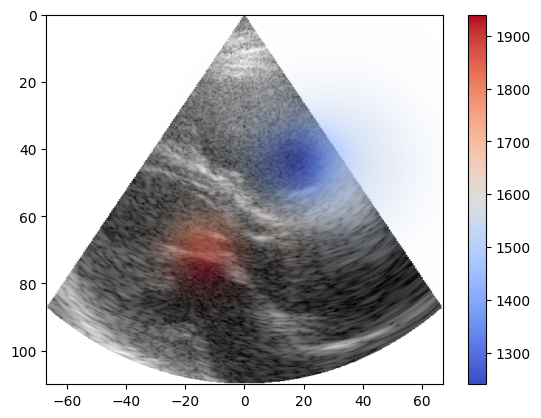

In [8]:
sos_values = get_speed_of_sound_values(scan150x150, -0.5)
data["speed_of_sound"] = HeterogeneousSpeedOfSound.from_scan(scan150x150, sos_values)
sos_result = beamformer(**data)

plt.imshow(sos_result.T, aspect="auto", cmap="gray", extent=extent, vmin=-80)
alpha = jnp.abs(sos_values.T - 1540)
alpha = alpha / jnp.max(alpha)*0.8
sos_overlay = plt.imshow(
    sos_values,
    aspect="auto",
    alpha=alpha,
    cmap="coolwarm",
    extent=extent,
)
plt.colorbar(sos_overlay)

# References
_[1] N. Bottenus, “Recovery of the Complete Data Set From Focused Transmit Beams,” IEEE Transactions on Ultrasonics, Ferroelectrics, and Frequency Control, vol. 65, no. 1, pp. 30–38, Jan. 2018, Conference Name: IEEE Transactions on Ultrasonics, Ferroelectrics, and Frequency Control, ISSN: 1525-8955. DOI: 10.1109/TUFFC. 2017.2773495._

_[2] A. Rodriguez-Molares, O. M. H. Rindal, O. Bernard, etal., “The UltraSound ToolBox,” in 2017 IEEE International Ultrasonics Symposium (IUS), ISSN: 1948-5727,Sep. 2017, pp. 1–4. DOI: 10 . 1109 / ULTSYM . 2017 .8092389._